This notebook is modified from mtwenzel's work: Transfer learning Inception-V3.
https://github.com/mtwenzel/parkinson-classification

# Classifying PPMI DAT scans into Parkinson's Disease and Healthy Controls

Licensed under [this](LICENSE) license.

This notebook shows how we performed the experiment to fine-tune the Inception V3 classifier to distinguish patients with and without signs of Parkinson's disease.

The notebook is optimized to work with Google Colab. It hides all code by default so that you can run it sequentially from top to bottom. If you want to see the implementation, just double-click into any cell, and it will open in a side-by-side view.

This code is part of the publication 
> Publication reference and [link](dummy-link-not-working-yet) to be inserted after publishing.

The data are a derivative of the DAT scans available from the [PPMI repository](https://www.ppmi-info.org/access-data-specimens/download-data/). They were processed to represent the central 5 slices of the putamen in one slice by averaging them. For details, please refer to the paper.

The data was then split randomly into a training and a validation set. As we tested the performance on an independant test set drawn from clinical routine which cannot be published, this notebook does not contain testing of the trained classifier.

The data as used in the publication can be downloaded here:

If you want to run the notebook from Google Colab, put the data into your Google Drive, and adapt the path below in the respective cell.

In [1]:
#@title Download and unzip the data. {display-mode:'form'}
#@markdown The data resides in the GitHub repository. For Hosted Runtime users, it is temporarily downloaded to the runtime's location.

from urllib.request import urlopen
from zipfile import ZipFile
zipurl = 'https://github.com/mtwenzel/parkinson-classification/raw/master/data/PPMI-classification.zip'
zipresp = urlopen(zipurl)
tempzip = open("PPMI-classification.zip", "wb")
tempzip.write(zipresp.read())
tempzip.close()
print("download complete, extracting...")

zf = ZipFile("PPMI-classification.zip")
zf.extractall(path = 'data/')
zf.close()
print("... done")

download complete, extracting...
... done


In [0]:
#@title Imports
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical, plot_model

# Visualize the Train/Val loss
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from sklearn.utils import shuffle
from scipy.signal import resample
from scipy import interp
from itertools import cycle, product

# 1 DataGenerator

In [3]:
#@title Set the data generators.
#@markdown Data augmentation choices. Cell runs automatically if anything is changed.
shear_range = 0.1 #@param {type:"slider", min:0.0, max:1.0, step:0.05}
zoom_range = 0.1 #@param {type:"slider", min:0.0, max:1.0, step:0.05}
width_shift_range = 0.1 #@param {type:"slider", min:0.0, max:1.0, step:0.05}
height_shift_range = 0.1 #@param {type:"slider", min:0.0, max:1.0, step:0.05}
rotation_range = 10 #@param {type:"slider", min:0, max:90, step:5}
horizontal_flip = True #@param {type:"boolean"}
vertical_flip = False #@param {type:"boolean"}
#@markdown Data source (No need to change if the download succeeded.)
data_directory = '/content/data/PPMI-classification/' #@param ['z:/Data/Parkinson_DATScans UKE/full_ppmi_data/png/', '/content/drive/My Drive/MEVIS/Data/PPMI-classification/'] {allow-input: true}

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=shear_range,
    zoom_range=zoom_range,
    width_shift_range=width_shift_range,
    height_shift_range=height_shift_range,
    rotation_range=rotation_range,
    horizontal_flip=horizontal_flip,
    vertical_flip=vertical_flip) 

train_generator = train_datagen.flow_from_directory(os.path.join(data_directory, 'all_2d_train'), # this is where you specify the path to the main data folder
                                                 target_size=(109,91),
                                                 color_mode='rgb',
                                                 batch_size=64,
                                                 class_mode='categorical',
                                                 shuffle=True)

# Data Generator for validation without data augmentation!
val_datagen   = ImageDataGenerator(rescale=1./255) 
val_generator = val_datagen.flow_from_directory(os.path.join(data_directory, 'all_2d_val'), # this is where you specify the path to the main data folder
                                                 target_size=(109,91),
                                                 color_mode='rgb',
                                                 batch_size=64,
                                                 class_mode='categorical',
                                                 shuffle=False)

Found 1097 images belonging to 2 classes.
Found 193 images belonging to 2 classes.


X_batch shape: (64, 109, 91, 3) 	y_batch shape: (64, 2)


/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


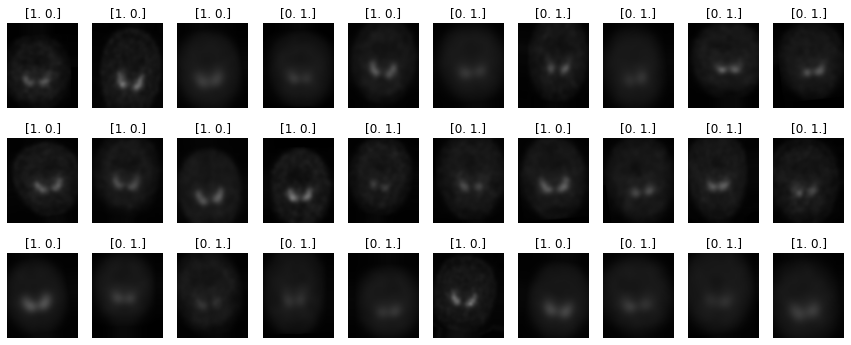

In [4]:
#@title Plot some training data from train_generator
X_batch, y_batch = train_generator.next()
print("X_batch shape:", X_batch.shape, "\ty_batch shape:", y_batch.shape)

w=10
h=10
fig=plt.figure(figsize=(15, 6))
columns = 10
rows = 3
for i in range(1, columns*rows +1):
    img = X_batch[i]
    fig.add_subplot(rows, columns, i)
    plt.title(y_batch[i])
    plt.axis('off')
    plt.imshow(img)
plt.show()

# 2 Model

In [14]:
#@title Build model with Functional API

inputs = Input(shape=(109, 91, 3))
x = Conv2D(64, kernel_size=(3,3), activation='relu')(inputs)
x = MaxPool2D((2, 2), strides=2)(x)
x = Dropout(rate=0.6)(x)
x = Conv2D(64, kernel_size=(3,3), activation='relu')(x)
x = MaxPool2D((2, 2), strides=2)(x)
x = Conv2D(96, kernel_size=(3,3), activation='relu')(x)
x = MaxPool2D((2, 2), strides=2)(x)
x = Conv2D(128, kernel_size=(3,3), activation='relu')(x)
x = MaxPool2D((2, 2), strides=2)(x)
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(rate=0.6)(x)
outputs = Dense(2, activation='softmax')(x)  # final layer with softmax activation

model = Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 109, 91, 3)]      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 107, 89, 64)       1792      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 53, 44, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 53, 44, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 51, 42, 64)        36928     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 25, 21, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 23, 19, 96)        5539

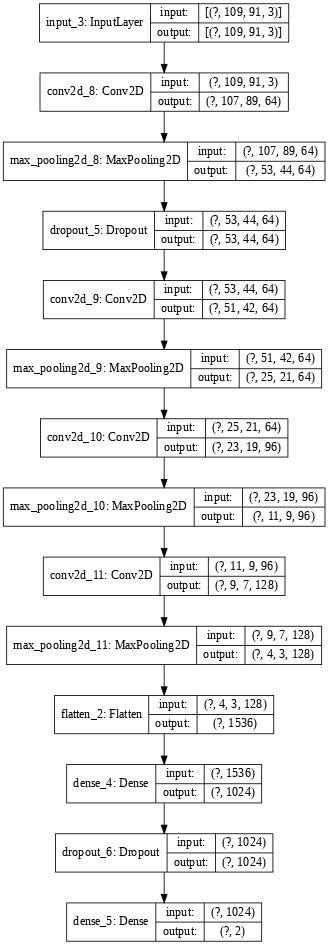

In [15]:
#@title plot model
plot_model(model, to_file="model_plot.png", show_shapes=True, dpi=60)

## compile model
Set up the trainable parameters. 

First train only the top layers (which were randomly initialized), i.e. freeze all convolutional InceptionV3 layers

In [0]:
#@title Set up trainable parameters
optimizer = 'adam' #@param ['adam', 'adagrad', 'adadelta', 'sgd'] {allow-input: true}

if optimizer in ['adam', 'adagrad', 'adadelta', 'sgd']: # standard settings
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics = ['accuracy']) # categorical crossentropy would also do...
else:
    from tensorflow.keras.optimizers import SGD
    model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='binary_crossentropy', metrics = ['accuracy'])

# 3 Training

In [17]:
#@title Run training
history = model.fit(
    train_generator, 
    steps_per_epoch=np.ceil(train_generator.n/train_generator.batch_size), 
    epochs=10, # Originally, 500 epochs! 
    validation_data=val_generator, 
    validation_steps=np.ceil(val_generator.n/val_generator.batch_size))

Epoch 1/10
18/18 [==============================] - 29s 2s/step - loss: 0.6513 - accuracy: 0.6983 - val_loss: 0.6344 - val_accuracy: 0.6788
Epoch 2/10
18/18 [==============================] - 29s 2s/step - loss: 0.6144 - accuracy: 0.6928 - val_loss: 0.4919 - val_accuracy: 0.7306
Epoch 3/10
18/18 [==============================] - 29s 2s/step - loss: 0.4902 - accuracy: 0.7593 - val_loss: 0.3822 - val_accuracy: 0.8031
Epoch 4/10
18/18 [==============================] - 29s 2s/step - loss: 0.4421 - accuracy: 0.7949 - val_loss: 0.4689 - val_accuracy: 0.8135
Epoch 5/10
18/18 [==============================] - 29s 2s/step - loss: 0.4019 - accuracy: 0.8131 - val_loss: 0.3708 - val_accuracy: 0.8238
Epoch 6/10
18/18 [==============================] - 29s 2s/step - loss: 0.4338 - accuracy: 0.8131 - val_loss: 0.3853 - val_accuracy: 0.8342
Epoch 7/10
18/18 [==============================] - 29s 2s/step - loss: 0.3771 - accuracy: 0.8396 - val_loss: 0.3930 - val_accuracy: 0.8238
Epoch 8/10
18/18 [==

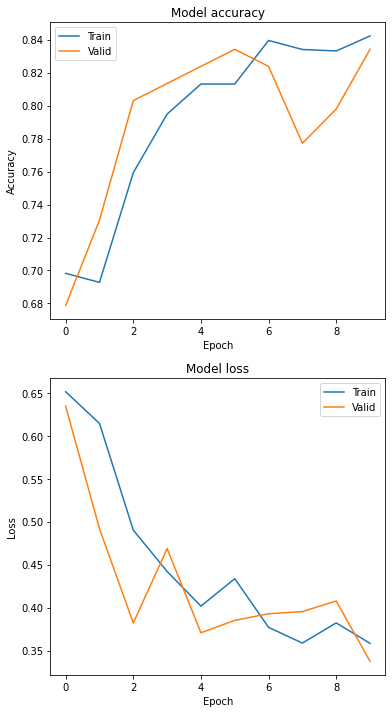

In [18]:
#@title Plot train and validation loss/accuracy
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6,12))

# Plot training & validation accuracy values
ax1.plot(history.history['accuracy'])  # fix
ax1.plot(history.history['val_accuracy'])  # fix
ax1.set_title('Model accuracy')
ax1.set(ylabel='Accuracy', xlabel='Epoch')
ax1.legend(['Train', 'Valid'], loc='upper left')

# Plot training & validation loss values
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('Model loss')
ax2.set(ylabel='Loss', xlabel='Epoch')
ax2.legend(['Train', 'Valid'], loc='upper right')

plt.savefig('train_history.png', dpi=72)  # <-- save plot
plt.show()

# 4 Test

In [19]:
#@title Prepare test data
CLASSES = list(val_generator.class_indices.keys())

y_test = val_generator.labels
y_test = to_categorical(y_test)  # as one-hot encoding

print("CLASSES:", CLASSES)
print("y_test:", y_test.shape)

CLASSES: ['HC', 'PD']
y_test: (193, 2)


In [20]:
#@title start inference model
y_pred = model.predict(val_generator, 
                       steps=np.ceil(val_generator.n/val_generator.batch_size), 
                       verbose=1)
print("y_pred shape =", y_pred.shape)

4/4 [==============================] - 1s 206ms/step
y_pred shape = (193, 2)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


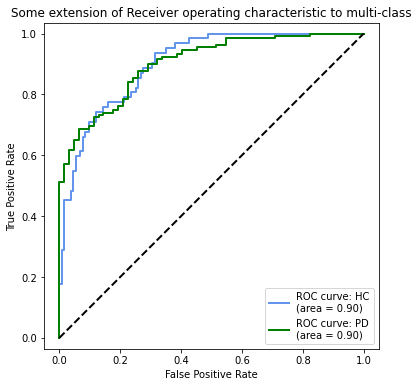

In [21]:
#@title plot ROC curve
#@title Compute ROC curve and ROC area for each class
N_CLASSES = len(CLASSES)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(N_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

lw = 2

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(N_CLASSES)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(N_CLASSES):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= N_CLASSES

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)

# plt.plot(fpr["micro"], tpr["micro"],
#          label='micro-average ROC curve (area = {0:0.2f})'
#                ''.format(roc_auc["micro"]),
#          color='deeppink', linestyle=':', linewidth=4)

# plt.plot(fpr["macro"], tpr["macro"],
#          label='macro-average ROC curve (area = {0:0.2f})'
#                ''.format(roc_auc["macro"]),
#          color='navy', linestyle=':', linewidth=4)

colors = cycle(['cornflowerblue', 'green', 'darkorange', 'red'])
for i, color in zip(range(N_CLASSES), colors):
    ax.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve: {0}\n(area = {1:0.2f})'
             ''.format(CLASSES[i], roc_auc[i]))

ax.plot([0, 1], [0, 1], 'k--', lw=lw)
ax.set(xlim=(0.0, 1.0), ylim=(0.0, 1.0))
ax.axis('equal')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Some extension of Receiver operating characteristic to multi-class')
ax.legend(loc="lower right")
plt.show()

<Figure size 432x288 with 0 Axes>

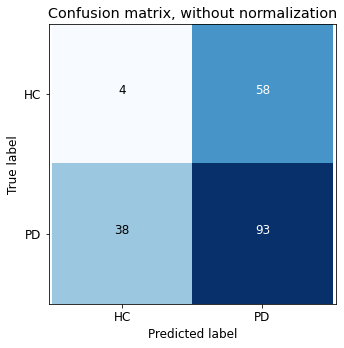

<Figure size 432x288 with 0 Axes>

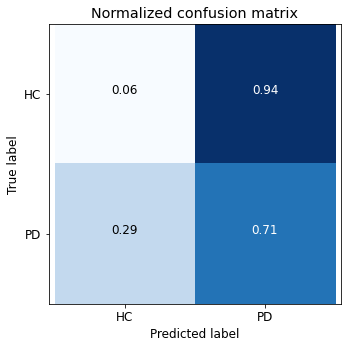

In [16]:
#@title plot confusion matrix
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html#sklearn.metrics.plot_confusion_matrix
class_names = CLASSES
plt.rcParams.update({'font.size': 12})

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
    else:
#         print('Confusion matrix, without normalization')
        pass

#     print(cm)

    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111)
    ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    ax.axis('equal')
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    plt.tight_layout()

# Compute confusion matrix
cnf_matrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [17]:
#@title classification report
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html?highlight=classification_report#sklearn.metrics.classification_report

print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1), target_names=CLASSES))

              precision    recall  f1-score   support

          HC       0.10      0.06      0.08        62
          PD       0.62      0.71      0.66       131

    accuracy                           0.50       193
   macro avg       0.36      0.39      0.37       193
weighted avg       0.45      0.50      0.47       193

